## Demo

In [1]:
#pip install -e .

from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [3]:
#DATASET_PATH = Path() / '..' / '..' / 'data' / 'midv500_compressed'
DATASET_PATH = Path() / '..' / '..' / '..' / '..' / '..' / '..' / 'Downloads' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [4]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [5]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)


(course_ocr_t1.data.MidvPackage, 300, course_ocr_t1.data.DataItem)

In [6]:
# DataItem содержит пути до файлов изображения и разметки
di.gt_path, di.img_path

(PosixPath('../../../../../../Downloads/midv500_compressed/19_esp_drvlic/ground_truth/PA/PA19_03.json'),
 PosixPath('../../../../../../Downloads/midv500_compressed/19_esp_drvlic/images/PA/PA19_03.png'))

In [7]:
# в gt_data (данные json) quad в абсолютных значениях (пиксели)
np.array(di.gt_data['quad'])

array([[284, 281],
       [692, 310],
       [670, 614],
       [262, 576]])

[[0.63111111 0.35125   ]
 [1.53777778 0.3875    ]
 [1.48888889 0.7675    ]
 [0.58222222 0.72      ]]


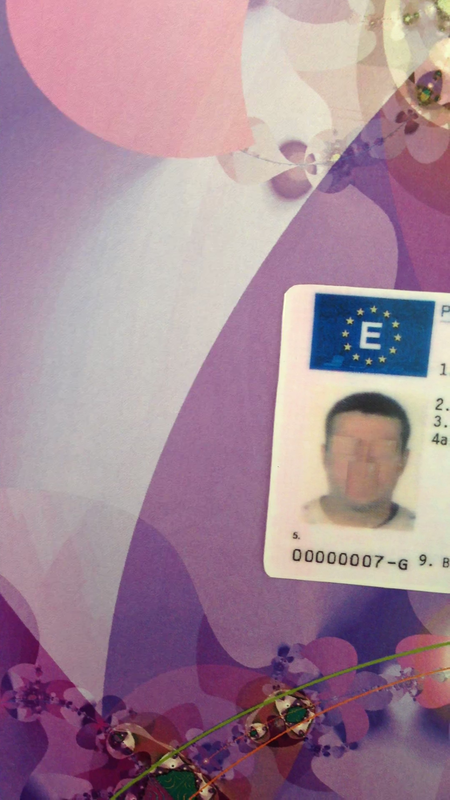

In [8]:
# Можно посмотреть изображения и разметку; в .quadrangle используются относительные единицы
print(di.quadrangle)
di.image

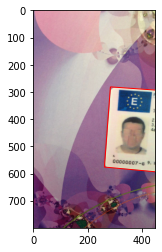

In [9]:
# Можно отрисовать разметку
# Не обязательно весь документ виден в кадре
di.show()

In [10]:
# DataItem содержит в себе информацию, относится ли он к test_split и целиком ли разметка внутри кадра
di.is_test_split(), di.is_quad_inside()

(False, False)

False


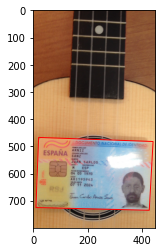

In [11]:
print(data_packs[38][238].is_test_split())
data_packs[38][238].show()

In [12]:
## Статистика, как часто разметка не целиком в кадре
is_quad_inside = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_quad_inside.append(dp[i].is_quad_inside())
is_quad_inside = np.array(is_quad_inside).astype(int)
print(f"В {is_quad_inside.sum()} из {len(is_quad_inside)} случаев разметка кропа(т.е. документ) целиком в кадре")

100%|██████████| 50/50 [00:02<00:00, 19.45it/s]

В 9992 из 15000 случаев разметка кропа(т.е. документ) целиком в кадре


In [13]:
## Статистика test-split
is_test_split = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_test_split.append(dp[i].is_test_split())
is_test_split = np.array(is_test_split).astype(int)
print(f"В {is_test_split.sum()} из {len(is_test_split)} случаев кадр принадлежит к test-split")

100%|██████████| 50/50 [00:00<00:00, 211.36it/s]

В 4250 из 15000 случаев кадр принадлежит к test-split


## Dataset preparation

In [1]:
#pip install -e .
#pip install  abbyy_course_cvdl_t2

from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

import torch

from task1pack.utils.data import HeatmapDataset

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_PATH = Path() / '..' / '..' / 'data' / 'midv500_compressed'
#DATASET_PATH = Path() / '..' / '..' / '..' / '..' / '..' / '..' / 'Downloads' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [3]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [4]:
from torchvision.transforms import Resize, Compose, ToTensor

IMAGE_SIZE = (400, 400)

transforms = Compose([
    ToTensor(),
    Resize(IMAGE_SIZE),
])

In [5]:
train_dataset = HeatmapDataset(data_packs=data_packs, split='train', transforms=transforms)
test_dataset = HeatmapDataset(data_packs=data_packs, split='test', transforms=transforms)

len(train_dataset), len(test_dataset)

(10750, 4250)

In [6]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([3, 400, 400]), torch.Size([4, 2]))

## Model

In [7]:
from task1pack.models.centernet import CenterNet

In [8]:
centernet = CenterNet(pretrained="resnet34", head_kwargs={'c_classes': 4})

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Sample model output

In [9]:
from torch.utils.data import DataLoader

from torch.nn import MSELoss
crit = MSELoss()

In [10]:
trainloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=8, shuffle=True, num_workers=2
    )

In [11]:
sample = next(iter(trainloader))
sample[0].shape, sample[1].shape

(torch.Size([8, 3, 400, 400]), torch.Size([8, 4, 2]))

In [12]:
ret = centernet(sample[0])
ret.shape

torch.Size([8, 4, 2])

In [13]:
a = crit(ret, sample[1])
a.shape

torch.Size([])

### Train

In [14]:
from task1pack.utils.train import train

In [15]:
net = train(test_dataset, net=centernet, criterion=crit, batch_size=8, epochs=30, lr=1e-3, device='cuda:3')

epoch 0|0; total loss:121739.953125
last losse: 6573957.5
epoch 0|54; total loss:320412.40625
last losse: 184.66519165039062
epoch 0|108; total loss:150.3363800048828
last losse: 133.8162078857422
epoch 0|162; total loss:123.80180358886719
last losse: 114.12499237060547
epoch 0|216; total loss:106.7024917602539
last losse: 99.90131378173828
epoch 0|270; total loss:93.31005096435547
last losse: 87.73085021972656
epoch 0|324; total loss:82.2431640625
last losse: 77.28544616699219
epoch 0|378; total loss:72.97356414794922
last losse: 68.72286224365234
epoch 0|432; total loss:65.24562072753906
last losse: 61.9013786315918
epoch 0|486; total loss:58.57563781738281
last losse: 56.28929138183594
epoch 1|0; total loss:0.9414881467819214
last losse: 50.84035873413086
epoch 1|54; total loss:48.66584777832031
last losse: 46.57903289794922
epoch 1|108; total loss:44.32198715209961
last losse: 42.26131820678711
epoch 1|162; total loss:40.51130676269531
last losse: 38.67592239379883
epoch 1|216; tot

epoch 11|162; total loss:0.4487082064151764
last losse: 0.4197462201118469
epoch 11|216; total loss:0.4456181526184082
last losse: 0.4160405397415161
epoch 11|270; total loss:0.42431750893592834
last losse: 0.38470226526260376
epoch 11|324; total loss:0.42368194460868835
last losse: 0.39343923330307007
epoch 11|378; total loss:0.39953771233558655
last losse: 0.35011908411979675
epoch 11|432; total loss:0.38690653443336487
last losse: 0.3948264420032501
epoch 11|486; total loss:0.3773553967475891
last losse: 0.3193080425262451
epoch 12|0; total loss:0.007190837990492582
last losse: 0.3883052468299866
epoch 12|54; total loss:0.35475218296051025
last losse: 0.42584627866744995
epoch 12|108; total loss:0.34540268778800964
last losse: 0.3123546242713928
epoch 12|162; total loss:0.32750415802001953
last losse: 0.2975600063800812
epoch 12|216; total loss:0.3215625584125519
last losse: 0.3195953369140625
epoch 12|270; total loss:0.3128608763217926
last losse: 0.3037804067134857
epoch 12|324; t

epoch 22|54; total loss:0.0652724876999855
last losse: 0.06321457028388977
epoch 22|108; total loss:0.0645466074347496
last losse: 0.06562235951423645
epoch 22|162; total loss:0.06826206296682358
last losse: 0.09699879586696625
epoch 22|216; total loss:0.06514459103345871
last losse: 0.06287209689617157
epoch 22|270; total loss:0.06757802516222
last losse: 0.05837376043200493
epoch 22|324; total loss:0.06557860970497131
last losse: 0.061211444437503815
epoch 22|378; total loss:0.0647355169057846
last losse: 0.05388699471950531
epoch 22|432; total loss:0.06615471094846725
last losse: 0.07089418172836304
epoch 22|486; total loss:0.06442460417747498
last losse: 0.05648349970579147
epoch 23|0; total loss:0.0009728764416649938
last losse: 0.05253532901406288
epoch 23|54; total loss:0.06520641595125198
last losse: 0.05713821202516556
epoch 23|108; total loss:0.06548983603715897
last losse: 0.0651504173874855
epoch 23|162; total loss:0.06437166035175323
last losse: 0.06759215146303177
epoch 2

### Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [16]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [ ]:
results_dict = {}
net.to('cpu')

for i, (x, _) in tqdm(enumerate(test_dataset)):
    result = centernet(x[None, ...])[0]
    key = test_dataset.get_key(i)
    results_dict[key] = result

875it [02:15,  1.83s/it]

In [ ]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [ ]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [ ]:
print("Точность кропа: {:1.4f}".format(acc))